In [1]:
# imports iniciales
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [9]:
training_labels = pd.read_csv("labels_training_set.csv", low_memory=False)
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
features = pd.read_csv('data_set.csv', low_memory = False)

In [10]:
features = features[['person', 'Direct', 'Email', 'Organic', 'Paid', 'Referral', 'Social', 'ad campaign hit', 'brand listing', 'checkout', 'conversion', 'generic listing', 'lead', 'search engine hit', 'searched products', 'staticpage', 'viewed product', 'visited site',  'promedio dias', 'promedio hora', 'retornos',  'coincide', 'sessions', 'total_time', 'mean_time_by_session', 'max_session_time', 'mean_events_by_session', 'max_events_by_session', 'days_since_last_session', 'longitud busqueda', 'promedio de TFIdf busquedas', 'Suma de TFidf busquedas', 'Maximo de TFIdf busquedas', 'Minimo de TFIdf busquedas', 'different_products_views', 'total_views', 'same_product_max_views', 'viewed/checkouted min', 'viewed/checkouted max', 'viewed/checkout gral', 'Computer', 'Smartphone', 'Tablet', 'country_Computer', 'country_Smartphone', 'country_Tablet', 'city', 'city_ranking', 'most_frequent_model', 'is_most_frequent_model_top', 'day', 'hora', 'hour', 'weekend',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'periodo_madrugada', 'periodo_manana',
       'periodo_mediodia', 'periodo_noche', 'periodo_tarde', 'mes_Apr',
       'mes_Feb', 'mes_Jan', 'mes_Mar', 'mes_May','storage_128GB', 'storage_16GB', 'storage_256GB',
       'storage_32GB', 'storage_4GB', 'storage_512MB', 'storage_64GB',
       'storage_8GB',
                    'event_ad campaign hit', 'event_brand listing',
       'event_checkout', 'event_conversion', 'event_generic listing',
       'event_lead', 'event_search engine hit', 'event_searched products',
       'event_staticpage', 'event_viewed product', 'event_visited site']]

In [11]:
events = pd.read_csv("events_up_to_01062018.csv", low_memory=False, dtype={'sku' : 'object'})
events['timestamp2'] = events['timestamp']
events['timestamp'] = pd.to_datetime(events['timestamp'], errors = 'coerce', format= '%Y-%m-%d')

In [12]:
# porcentaje de ventas por modelo
modelos = events[events['event'] == 'conversion'].groupby('model').agg({'timestamp':'count'}).reset_index()
total_ventas = modelos['timestamp'].sum()
modelos['timestamp'] = modelos['timestamp'] / total_ventas * 100
modelos.columns = ['model', 'porcent']
modelos.head()

,model,porcent
0,Asus Zenfone 2,0.070512
1,Asus Zenfone 2 Laser,0.014102
2,"Asus Zenfone 2 Laser 6""",0.014102
3,Asus Zenfone 3 Max 32 GB,0.084614
4,Asus Zenfone 3 Max 16 GB,0.112819


In [13]:
events['marca'] = pd.Categorical(events['model'].str.split(' ').str[0])

In [14]:
# porcentaje de ventas por marca
marca = events[events['event'] == 'conversion'].groupby('marca').agg({'timestamp':'count'}).reset_index()
total_ventas = marca['timestamp'].sum()
marca['timestamp'] = marca['timestamp'] / total_ventas * 100
marca.columns = ['marca', 'porcent']
marca.head()

,marca,porcent
0,Asus,0.310252
1,LG,2.270484
2,Lenovo,1.396136
3,Motorola,15.569031
4,Outros,0.000000


In [15]:
# porcentaje de ventas por color
colors = events[events['event'] == 'conversion'].groupby('color').agg({'timestamp':'count'}).reset_index()
total_ventas = colors['timestamp'].sum()
colors['timestamp'] = colors['timestamp'] / total_ventas * 100
colors.columns = ['color', 'porcent']
colors.head()

,color,porcent
0,Amarelo,0.014102
1,Ametista,0.578198
2,Azul,1.198703
3,Azul Escuro,0.042307
4,Azul Topázio,0.014102


In [16]:
events = pd.merge(events, modelos, on='model', how='left', suffixes=['','-model'])
events = pd.merge(events, marca, on='marca', how='left', suffixes=['','-marca'])
events = pd.merge(events, colors, on='color', how='left', suffixes=['','-color'])

In [17]:
events[['person','porcent','porcent-marca','porcent-color']].head()

,person,porcent,porcent-marca,porcent-color
0,4886f805,3.088422,50.980116,24.241997
1,ad93850f,6.994782,28.543224,7.022987
2,0297fc1e,4.329432,28.543224,4.343534
3,2d681dd8,1.226907,28.543224,0.183331
4,cccea85e,0.098717,2.270484,12.804964


In [18]:
suma = events.groupby('person').agg({'porcent':'sum','porcent-marca':'sum','porcent-color':'sum'})

In [19]:
features = pd.merge(features, suma, on='person', how='left')
features = features.fillna(0)

In [20]:
compras = events[events['event'] == 'conversion'].groupby('person').agg({'timestamp':['max','count']}).reset_index()
compras.columns = ['person','ult-compra','ctd-compras']
compras.head()

,person,ult-compra,ctd-compras
0,000ba417,2018-05-26 13:09:22,1
1,001001be,2018-05-16 19:31:00,1
2,001804a2,2018-05-25 18:17:40,1
3,0019e639,2018-05-22 22:13:09,2
4,001b0bf9,2018-05-22 14:23:46,1


In [21]:
compras['ult-compra'] = pd.datetime.today() - compras['ult-compra']
compras['ult-compra'] = compras['ult-compra'].dt.days
compras.head()

,person,ult-compra,ctd-compras
0,000ba417,192,1
1,001001be,201,1
2,001804a2,192,1
3,0019e639,195,2
4,001b0bf9,196,1


In [22]:
features = pd.merge(features, compras, on='person', how='left')
features = features.fillna(0)
features.head()

,person,Direct,Email,Organic,Paid,Referral,Social,ad campaign hit,brand listing,checkout,...,event_search engine hit,event_searched products,event_staticpage,event_viewed product,event_visited site,porcent,porcent-marca,porcent-color,ult-compra,ctd-compras
0,0008ed71,2.0,0.0,0.0,0.0,0.0,0.0,0,0,3,...,0.0,0.0,0.0,0.0,17.0,3.652517,81.793823,63.954308,0.0,0.0
1,00091926,1.0,0.0,25.0,0.0,0.0,0.0,15,25,2,...,0.0,0.0,0.0,3102.5,275.5,747.087858,11194.344944,5874.940065,0.0,0.0
2,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,...,0.0,0.0,0.0,6.0,2.0,10.985757,85.629671,34.339303,0.0,0.0
3,000ba417,0.0,0.0,6.0,0.0,0.0,0.0,1,24,6,...,8.5,0.0,0.0,1749.0,63.5,195.374418,6422.084332,3131.152165,192.0,1.0
4,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,...,14.5,130.5,0.0,43.5,14.5,4.907629,114.172895,3.948667,0.0,0.0


In [23]:
########## https://jessesw.com/XG-Boost/

In [24]:
len(list(features.columns))

95

In [25]:
print(training_labels.shape)
training_labels = pd.merge(features, training_labels, on='person', how='inner')
#training_labels = training_labels[['person','label','ad campaign hit', 'brand listing', 'checkout', 'conversion', 'search engine hit', 'time_score', 'promedio dias', 'storage_16GB', 'storage_8GB', 'marca_Samsung', 'marca_iPhone', 'color_Branco Framboesa', 'color_Dourado', 'color_Preto', 'color_Preto Brilhante', 'color_Preto Matte', 'color_Rosa', 'coincide', 'sessions', 'total_time', 'mean_time_by_session', 'max_session_time', 'mean_events_by_session', 'max_events_by_session', 'days_since_last_session', 'Suma de TFidf busquedas', 'Minimo de TFIdf busquedas', 'same_product_max_views', 'viewed/checkout gral', 'Computer', 'Smartphone', 'city', 'city_ranking', 'most_frequent_model', 'skusum', 'daysum', 'horasum', 'weekday_Sundaysum', 'weekday_Wednesdaysum', 'periodo_nochesum', 'mes_Febsum', 'mes_Maysum', 'skumean', 'weekday_Mondaymean', 'weekday_Thursdaymean', 'periodo_madrugadamean', 'mes_Maymean', 'suma', 'promedio', 'maximo', 'minimo', 'suma_resolution', 'promedio_resolution', 'maximo_resolution', 'promedio de TFIdf modelo', 'Suma de TFidf modelo']]
print(training_labels.shape)
training_labels.head(2)

(19414, 2)
(19414, 96)


,person,Direct,Email,Organic,Paid,Referral,Social,ad campaign hit,brand listing,checkout,...,event_searched products,event_staticpage,event_viewed product,event_visited site,porcent,porcent-marca,porcent-color,ult-compra,ctd-compras,label
0,0008ed71,2.0,0.0,0.0,0.0,0.0,0.0,0,0,3,...,0.0,0.0,0.0,17.0,3.652517,81.793823,63.954308,0.0,0.0,0
1,000c79fe,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,...,130.5,0.0,43.5,14.5,4.907629,114.172895,3.948667,0.0,0.0,0


In [26]:
print(labels_predict.shape)
labels_predict = pd.merge(features, labels_predict, on='person', how='inner')
#labels_predict = labels_predict[['person','ad campaign hit', 'brand listing', 'checkout', 'conversion', 'search engine hit', 'time_score', 'promedio dias', 'storage_16GB', 'storage_8GB', 'marca_Samsung', 'marca_iPhone', 'color_Branco Framboesa', 'color_Dourado', 'color_Preto', 'color_Preto Brilhante', 'color_Preto Matte', 'color_Rosa', 'coincide', 'sessions', 'total_time', 'mean_time_by_session', 'max_session_time', 'mean_events_by_session', 'max_events_by_session', 'days_since_last_session', 'Suma de TFidf busquedas', 'Minimo de TFIdf busquedas', 'same_product_max_views', 'viewed/checkout gral', 'Computer', 'Smartphone', 'city', 'city_ranking', 'most_frequent_model', 'skusum', 'daysum', 'horasum', 'weekday_Sundaysum', 'weekday_Wednesdaysum', 'periodo_nochesum', 'mes_Febsum', 'mes_Maysum', 'skumean', 'weekday_Mondaymean', 'weekday_Thursdaymean', 'periodo_madrugadamean', 'mes_Maymean', 'suma', 'promedio', 'maximo', 'minimo', 'suma_resolution', 'promedio_resolution', 'maximo_resolution', 'promedio de TFIdf modelo', 'Suma de TFidf modelo']]
print(labels_predict.shape)
labels_predict.head(2)

(19415, 1)
(19415, 95)


,person,Direct,Email,Organic,Paid,Referral,Social,ad campaign hit,brand listing,checkout,...,event_search engine hit,event_searched products,event_staticpage,event_viewed product,event_visited site,porcent,porcent-marca,porcent-color,ult-compra,ctd-compras
0,00091926,1.0,0.0,25.0,0.0,0.0,0.0,15,25,2,...,0.0,0.0,0.0,3102.5,275.5,747.087858,11194.344944,5874.940065,0.0,0.0
1,00091a7a,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,...,0.0,0.0,0.0,6.0,2.0,10.985757,85.629671,34.339303,0.0,0.0


In [27]:
labels = training_labels['label']
features = training_labels.drop(['label','person'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
print("Train: ",len(x_train),"Test: ",len(x_test))

Train:  14560 Test:  4854


In [36]:
model = xgb.XGBClassifier(learning_rate =0.075, n_estimators=95, max_depth=4, min_child_weight=6, 
                         gamma=0.3, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                         scale_pos_weight=0.8, seed = 15)
model.fit(features, labels)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.075,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=95, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.8, seed=15, silent=True,
       subsample=0.8)

In [39]:
scores = cross_val_score(model, features, labels, scoring="roc_auc", cv=5)

In [40]:
scores

array([0.87331385, 0.87952846, 0.86965234, 0.86313191, 0.87506782])

In [44]:
set_test = labels_predict
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)

In [65]:
predicts_kaggel = model.predict_proba(set_test)
predicts_kaggel

array([[0.98036885, 0.01963116],
       [0.92516017, 0.07483986],
       [0.96017987, 0.03982015],
       ...,
       [0.9949227 , 0.00507731],
       [0.99726343, 0.00273657],
       [0.9970627 , 0.00293729]], dtype=float32)

In [66]:
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19415 entries, 0 to 19414
Data columns (total 2 columns):
0    19415 non-null float32
1    19415 non-null float32
dtypes: float32(2)
memory usage: 151.8 KB


In [68]:
df_kaggel = pd.DataFrame(df_kaggel[1])
df_kaggel.head()

,1
0,0.019631
1,0.074840
2,0.039820
3,0.021158
4,0.012799


In [69]:
df_kaggel["person"] = personas
df_kaggel.rename(columns = {1: 'label'},inplace = True) 
df_kaggel = df_kaggel[['person','label']]

In [71]:
df_kaggel.to_csv('ResultadosXGB.csv',index=False)

In [ ]:
#######fin

In [10]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'criterion' : 'entropy'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [131]:
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, criterion='entropy', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [132]:
optimized_GBM.grid_scores_

[mean: 0.94863, std: 0.00177, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.94863, std: 0.00128, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.94815, std: 0.00095, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.94911, std: 0.00133, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.94835, std: 0.00137, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.94773, std: 0.00143, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.94945, std: 0.00126, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.94856, std: 0.00165, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.94842, std: 0.00140, params: {'max_depth': 7, 'min_child_weight': 5}]

In [133]:
optimized_GBM.best_params_

{'max_depth': 7, 'min_child_weight': 1}

In [134]:
cv_params = {'learning_rate': [0.1,0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'criterion' : 'entropy',
              'max_depth': 7
              , 'min_child_weight': 1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [135]:
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, criterion='entropy', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [136]:
optimized_GBM.grid_scores_

[mean: 0.94973, std: 0.00056, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.94945, std: 0.00126, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.94911, std: 0.00070, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.95055, std: 0.00104, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.95096, std: 0.00093, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.95096, std: 0.00118, params: {'learning_rate': 0.01, 'subsample': 0.9}]

In [137]:
optimized_GBM.best_params_

{'learning_rate': 0.01, 'subsample': 0.8}

In [138]:
cv_params = {'scale_pos_weight': [0.8,18]}
ind_params = {'eta':  0.01, 'subsample':  0.8, 'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'criterion' : 'entropy',
              'max_depth': 7, 'min_child_weight': 1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, criterion='entropy', eta=0.01, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scale_pos_weight': [0.8, 18]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [139]:
optimized_GBM.grid_scores_

[mean: 0.94952, std: 0.00092, params: {'scale_pos_weight': 0.8},
 mean: 0.94567, std: 0.00088, params: {'scale_pos_weight': 18}]

In [140]:
optimized_GBM.best_params_

{'scale_pos_weight': 0.8}

In [31]:
xgdmat = xgb.DMatrix(features, labels)

In [32]:
our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'criterion' : 'entropy',
              'max_depth':5, 'min_child_weight':1} 

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'],
                early_stopping_rounds = 100)

[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:09:53] /work

[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:56] /work

[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:09:59] /work

[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:02] /work

[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:05] /work

[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:10:09] /work

[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:10:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:12] /work

[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:10:15] /work

In [33]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
1,0.046796,0.001111,0.050222,0.001819
2,0.046423,0.001315,0.050376,0.002223
3,0.046539,0.000844,0.050118,0.002340
4,0.046423,0.000925,0.049964,0.002261
5,0.046345,0.000816,0.049809,0.002217


In [35]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 
              'max_depth':3, 'min_child_weight':1} 

## round se saca de arriba 
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 28)

[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:12:17] /work

In [98]:
##########

In [99]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

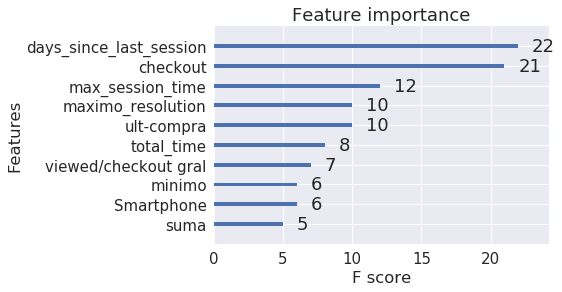

In [100]:
xgb.plot_importance(final_gb, max_num_features=10) # fixear

In [101]:
importances = final_gb.get_fscore()
importances

{'checkout': 21,
 'max_session_time': 12,
 'storage_8GB': 5,
 'promedio dias': 3,
 'days_since_last_session': 22,
 'day': 5,
 'ult-compra': 10,
 'maximo_resolution': 10,
 'marca_LG': 2,
 'Smartphone': 6,
 'maximo': 5,
 'most_frequent_model': 2,
 'Computer': 4,
 'total_time': 8,
 'coincide': 3,
 'viewed product': 2,
 'city_ranking': 3,
 'marca_Samsung': 3,
 'weekday_Sunday': 2,
 'storage_128GB': 2,
 'sessions': 1,
 'viewed/checkout gral': 7,
 'Direct': 3,
 'condition_Muito Bom': 1,
 'conversion': 2,
 'suma_resolution': 4,
 'periodo_noche': 1,
 'promedio de TFIdf busquedas': 2,
 'mean_time_by_session': 2,
 'minimo': 6,
 'Maximo de TFIdf busquedas': 1,
 'marca_iPhone': 5,
 'weekday_Monday': 1,
 'searched products': 1,
 'suma': 5,
 'Referral': 2,
 'porcent': 2,
 'generic listing': 1,
 'weekday_Friday': 1,
 'condition_Bom': 1,
 'city': 2,
 'promedio': 2,
 'weekday_Wednesday': 1,
 'Minimo de TFIdf busquedas': 2,
 'same_product_max_views': 3,
 'Suma de TFidf busquedas': 1,
 'is_most_frequent_

In [102]:
#######

In [103]:
testdmat = xgb.DMatrix(x_test)

In [104]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat)
y_pred

array([0.04065286, 0.03725692, 0.04866177, ..., 0.04113222, 0.03725692,
       0.19838545], dtype=float32)

In [105]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [106]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.9482900700453234, 0.0517099299546766)

In [107]:
###########

In [108]:
set_test = labels_predict
set_test.columns

Index(['person', 'Direct', 'Email', 'Organic', 'Paid', 'Referral', 'Social',
       'ad campaign hit', 'brand listing', 'checkout',
       ...
       'minimo', 'suma_resolution', 'promedio_resolution', 'maximo_resolution',
       'minimo_resolution', 'porcent', 'porcent-marca', 'porcent-color',
       'ult-compra', 'ctd-compras'],
      dtype='object', length=109)

In [109]:
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)

final_test = set_test
testdmat = xgb.DMatrix(final_test)

In [110]:
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([0.10786028, 0.13522339, 0.08409238, ..., 0.03725692, 0.03725692,
       0.03725692], dtype=float32)

In [111]:
predicts_kaggel = y_pred.tolist()


In [112]:
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0.107860
1,0.135223
2,0.084092
3,0.081956
4,0.043194


In [113]:
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [114]:
df_kaggel = df_kaggel[['person','label']]

In [115]:
df_kaggel.to_csv('Resultados_new_xgb.csv',index=False)